In [4]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import rasterio

# ====== RUTAS ======
masked_dir = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_masked_20251210")
out_csv = masked_dir.parent / "features_20251210.csv"

# Bandas: 0:B, 1:G, 2:R, 3:RE, 4:NIR
B_IDX, G_IDX, R_IDX, RE_IDX, NIR_IDX = 0, 1, 2, 3, 4

def parse_plot_id(name: str) -> int:
    m = re.search(r"plot_(\d+)_LUM_RL_masked\.tif$", name)
    return int(m.group(1)) if m else None

def safe_mean(x):
    """Promedio ignorando NaN, devuelve NaN si no hay datos."""
    x = np.asarray(x, dtype=np.float32)
    if np.isfinite(x).sum() == 0:
        return np.nan
    return float(np.nanmean(x))

def idx_nd(numer, denom, eps=1e-6):
    return numer / (denom + eps)

# ====== ÍNDICES (paper) ======
def NDVI(nir, red):
    return idx_nd(nir - red, nir + red)

def SR(nir, red):
    return idx_nd(nir, red)

def CHLGR(nir, green):
    # CHLGR = (B5/B2) - 1
    return idx_nd(nir, green) - 1.0

def MARI(green, red_edge):
    # MARI = (1/B2) - (1/B4)
    return (1.0 / (green + 1e-6)) - (1.0 / (red_edge + 1e-6))

def OSAVI(nir, green, L=0.16):
    # OSAVI = (1+L)*(B5-B2)/(B5+B2+L)  (según paper)
    return (1.0 + L) * idx_nd(nir - green, nir + green + L)

def SAVI2(nir, red, a=0.01, b=1.43):
    # SAVI2 = B5 / (B3 + (b/a))  (paper: a=0.01, b=1.43)
    return idx_nd(nir, red + (b / a))

print("masked_dir:", masked_dir)
print("out_csv:", out_csv)


masked_dir: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_masked_20251210
out_csv: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\features_20251210.csv


In [5]:
masked_files = sorted(masked_dir.glob("plot_*_LUM_RL_masked.tif"))
if len(masked_files) == 0:
    raise FileNotFoundError(f"No encontré 'plot_*_LUM_RL_masked.tif' en {masked_dir}")

rows = []

for fp in masked_files:
    pid = parse_plot_id(fp.name)

    with rasterio.open(fp) as src:
        RL = src.read().astype(np.float32)  # (5,H,W)

    B  = RL[B_IDX]
    G  = RL[G_IDX]
    R  = RL[R_IDX]
    RE = RL[RE_IDX]
    N  = RL[NIR_IDX]

    # VF: % pixeles válidos (no-NaN) después del masked (suelo = NaN)
    # usamos NIR como referencia de validez
    valid = np.isfinite(N)
    VF = float(valid.sum() / valid.size)

    # índices por píxel (NaNs se propagan)
    ndvi = NDVI(N, R)
    sr   = SR(N, R)
    chlgr = CHLGR(N, G)
    mari = MARI(G, RE)
    osavi = OSAVI(N, G, L=0.16)
    savi2 = SAVI2(N, R, a=0.01, b=1.43)

    # promedios por plot
    row = {
        "plot_id": pid,
        "VF": VF,
        "NDVI_mean": safe_mean(ndvi),
        "SR_mean": safe_mean(sr),
        "CHLGR_mean": safe_mean(chlgr),
        "MARI_mean": safe_mean(mari),
        "OSAVI_mean": safe_mean(osavi),
        "SAVI2_mean": safe_mean(savi2),
        "valid_pixels": int(valid.sum()),
        "total_pixels": int(valid.size),
    }
    rows.append(row)

df = pd.DataFrame(rows).sort_values("plot_id")
df.to_csv(out_csv, index=False)

print("✅ Features guardadas en:", out_csv)
df.head()


✅ Features guardadas en: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\features_20251210.csv


,plot_id,VF,NDVI_mean,SR_mean,CHLGR_mean,MARI_mean,OSAVI_mean,SAVI2_mean,valid_pixels,total_pixels
110,1,0.091534,0.740399,6.728218,2.853492,4.443617,0.544906,3.851346e-03,8768,95790
124,2,0.096375,0.803311,9.198384,3.428803,3.839409,0.611442,4.959710e-03,9202,95481
135,3,0.134983,0.805371,8.733396,3.069994,27505.001953,0.000487,6.130523e-07,12930,95790
146,4,0.095709,0.756601,6.849193,2.614598,24947.978516,0.000439,5.749103e-07,9168,95790
157,5,0.121769,0.828403,9.851377,3.508522,37030.667969,0.000425,5.173079e-07,11702,96100


Total plots: 202
VF min/mean/max: 0.043777315296566 0.11537870280455519 0.2422164412070759


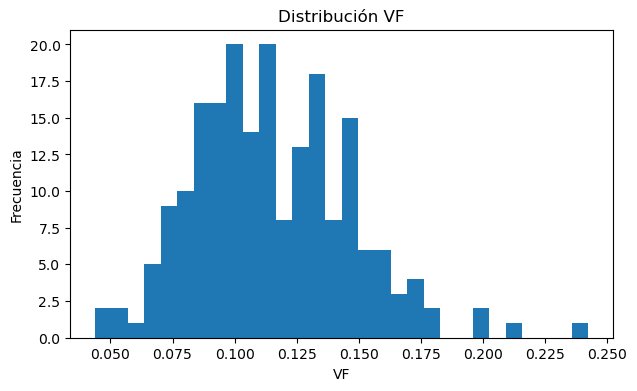

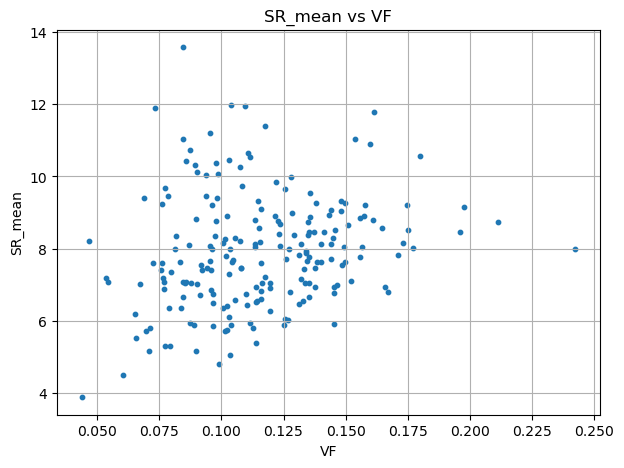


Plots con menos pixeles válidos:


,plot_id,VF,NDVI_mean,SR_mean,CHLGR_mean,MARI_mean,OSAVI_mean,SAVI2_mean,valid_pixels,total_pixels
18,19,0.043777,0.589988,3.880904,2.201031,3.321711,0.490989,3.906022e-03,4207,96100
68,69,0.046842,0.781145,8.203262,3.495731,4.754133,0.596418,4.191537e-03,4487,95790
52,53,0.053377,0.754606,7.173693,3.162093,4.792064,0.562793,3.736794e-03,5113,95790
162,163,0.054348,0.764789,7.070906,3.321222,38606.175781,0.000373,4.575866e-07,5206,95790
57,58,0.060302,0.651808,4.504935,1.931404,27761.613281,0.000285,4.055568e-07,5795,96100
76,77,0.065236,0.721338,6.195560,2.583843,4.501845,0.506598,3.271947e-03,6249,95790
83,84,0.065456,0.710791,5.522833,2.122578,33730.265625,0.000269,3.695351e-07,6270,95790
200,201,0.067063,0.765140,7.030865,2.754238,35847.765625,0.000337,4.317449e-07,6424,95790
20,21,0.068988,0.817593,9.413272,3.593486,27545.468750,0.000584,7.110993e-07,6587,95481
123,124,0.069595,0.702110,5.721502,2.342696,3.547763,0.503497,3.893075e-03,6645,95481


In [6]:
import matplotlib.pyplot as plt

df = pd.read_csv(out_csv)

print("Total plots:", len(df))
print("VF min/mean/max:", df["VF"].min(), df["VF"].mean(), df["VF"].max())

# VF hist
plt.figure(figsize=(7,4))
plt.hist(df["VF"].dropna(), bins=30)
plt.title("Distribución VF")
plt.xlabel("VF")
plt.ylabel("Frecuencia")
plt.show()

# SR vs VF (sanity check)
plt.figure(figsize=(7,5))
plt.scatter(df["VF"], df["SR_mean"], s=10)
plt.title("SR_mean vs VF")
plt.xlabel("VF")
plt.ylabel("SR_mean")
plt.grid(True)
plt.show()

# Top 10 con menos pixels válidos (posibles problemas de máscara)
print("\nPlots con menos pixeles válidos:")
display(df.sort_values("valid_pixels").head(10))
